In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet


pd.options.display.float_format = '{:,.0f}'.format

2025-06-03 21:36:46.994 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



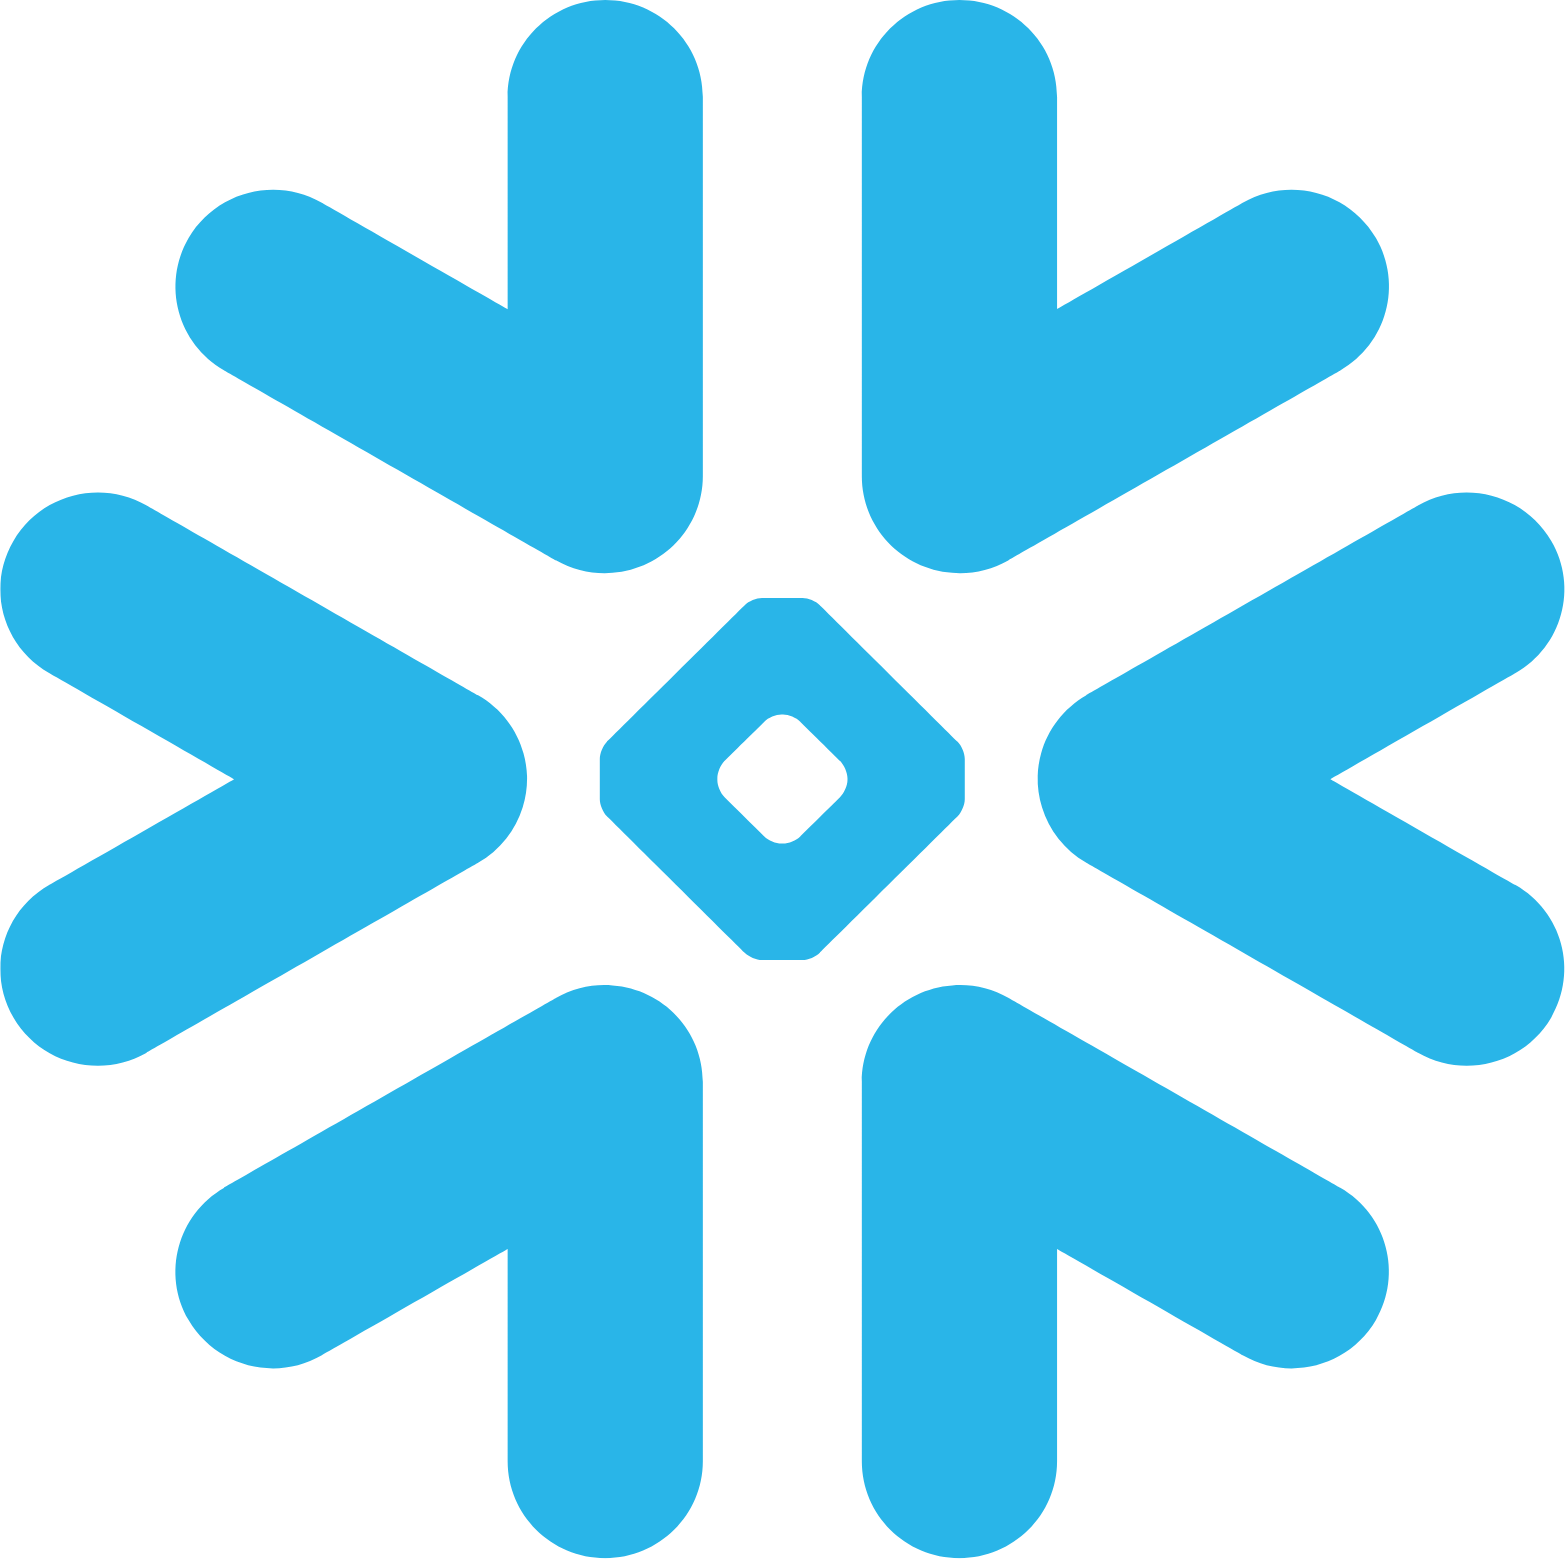

In [6]:
df = pd.read_csv('cash_flow_data.csv')
df.head()

In [7]:
# Ensure you have these columns; adjust if your names differ
df['Month_dt'] = pd.to_datetime(df['Month'], format='%b-%Y')  

In [8]:
# List your inflow/outflow columns here:
inflow_cols = [
    "Tuition Revenue", "State Appropriation", "Federal Grants",
    "Research Grants", "Donations & Endowments", "Auxiliary Services Income",
    "Continuing Education Fees"
]
outflow_cols = [
    "Faculty Salaries", "Staff Salaries", "Scholarship Disbursements",
    "Facilities Maintenance", "Utility Expenses", "IT Infrastructure Costs",
    "Academic Program Costs", "Student Services", "Administrative Expenses",
    "Marketing & Outreach", "Debt Service"
]

In [9]:
# Compute totals if needed
if "Total Inflow" not in df:
    df["Total Inflow"] = df[inflow_cols].sum(axis=1)
if "Total Outflow" not in df:
    df["Total Outflow"] = df[outflow_cols].sum(axis=1)
if "Net Cash Flow" not in df:
    df["Net Cash Flow"] = df["Total Inflow"] - df["Total Outflow"]

In [10]:
# ─── 2) Summary Statistics ────────────────────────────────────────────────
print("=== Summary Statistics ===")
print(df[["Total Inflow","Total Outflow","Net Cash Flow"]].describe(), "\n")
# Interpretation: check mean/std to gauge overall cash health.

=== Summary Statistics ===
       Total Inflow  Total Outflow  Net Cash Flow
count            24             24             24
mean      8,418,016      5,482,461      2,935,555
std         293,253        268,249        380,884
min       7,757,594      4,966,378      2,253,994
25%       8,283,520      5,343,018      2,608,093
50%       8,393,850      5,467,604      2,924,358
75%       8,581,948      5,643,825      3,246,538
 ax       8,955,711      5,957,104      3,507,868



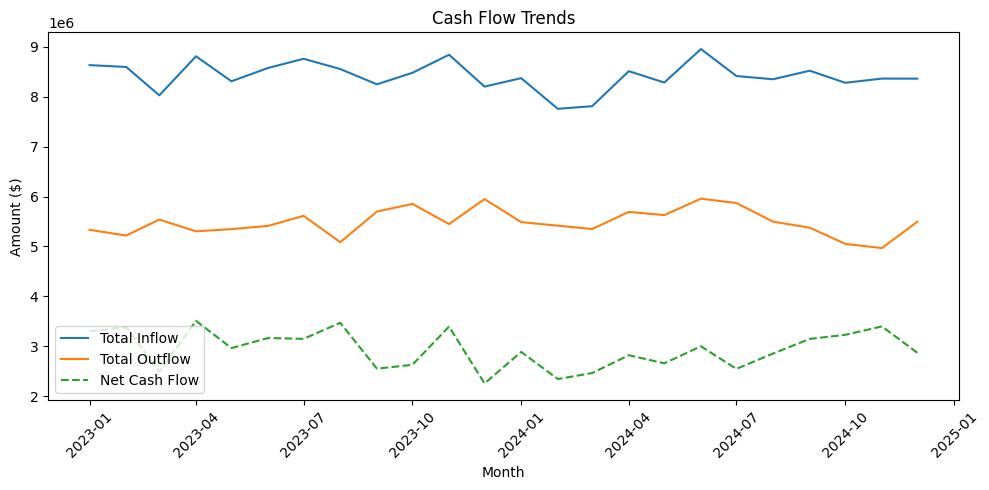

In [11]:
# ─── 3) Trend Over Time ───────────────────────────────────────────────────
plt.figure(figsize=(10,5))
plt.plot(df["Month_dt"], df["Total Inflow"], label="Total Inflow")
plt.plot(df["Month_dt"], df["Total Outflow"], label="Total Outflow")
plt.plot(df["Month_dt"], df["Net Cash Flow"], linestyle="--", label="Net Cash Flow")
plt.title("Cash Flow Trends")
plt.xlabel("Month")
plt.ylabel("Amount ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Interpretation: spot peaks/troughs and seasonality.

In [12]:
# ─── 4) Average Category Contributions ────────────────────────────────────
print("=== Avg Inflow by Category ===")
print(df[inflow_cols].mean().sort_values(ascending=False), "\n")
print("=== Avg Outflow by Category ===")
print(df[outflow_cols].mean().sort_values(ascending=False), "\n")

=== Avg Inflow by Category ===
Tuition Revenue             3,470,472
State Appropriation         1,960,556
Research Grants             1,173,484
Federal Grants                809,683
Auxiliary Services Income     492,827
Donations & Endowments        302,525
Continuing Education Fees     208,469
 type: float64

=== Avg Outflow by Category ===
Faculty Salaries            1,503,524
Staff Salaries              1,031,684
Scholarship Disbursements     592,285
Debt Service                  514,040
Facilities Maintenance        393,261
Academic Program Costs        362,076
Utility Expenses              300,160
IT Infrastructure Costs       255,847
Student Services              193,108
Administrative Expenses       186,078
Marketing & Outreach          150,399
 type: float64



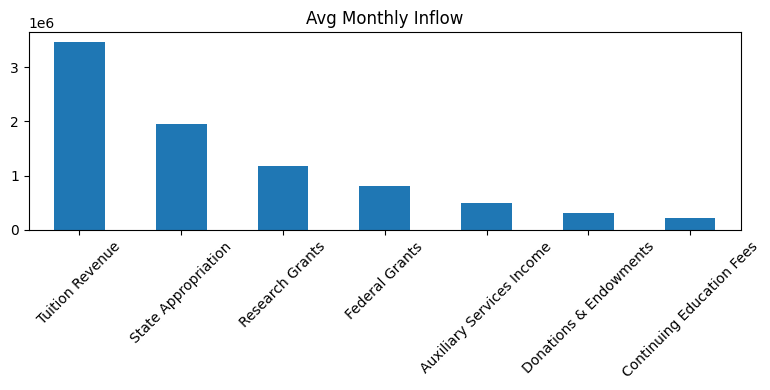

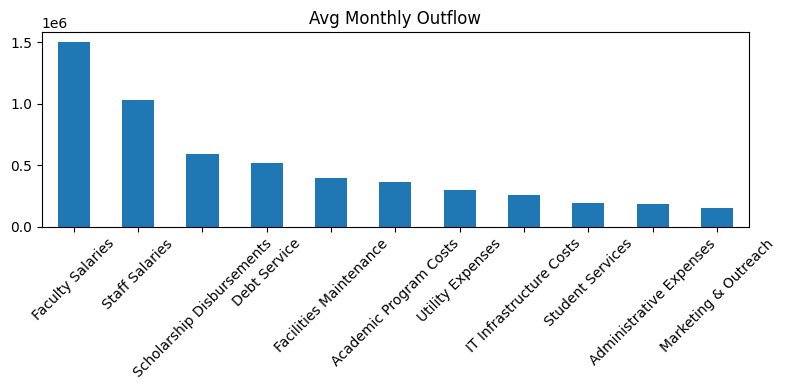

In [13]:
# Optional bar charts
df[inflow_cols].mean().sort_values(ascending=False).plot(
    kind="bar", figsize=(8,4), title="Avg Monthly Inflow")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

df[outflow_cols].mean().sort_values(ascending=False).plot(
    kind="bar", figsize=(8,4), title="Avg Monthly Outflow")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()
# Interpretation: see which items drive most cash movement.

In [18]:
# 3) Compute seasonality amplitude
season_amp = {}
df['Month_Num'] = df['Month_dt'].dt.month
for cat in inflow_cols:
    monthly_avg = df.groupby('Month_Num')[cat].mean()
    amp = monthly_avg.max() - monthly_avg.min()
    season_amp[cat] = amp

season_amp = pd.Series(season_amp).sort_values(ascending=False)
print("Seasonal Amplitude (highest to lowest):")
print(season_amp.to_frame('Amplitude'), "\n")

Seasonal Amplitude (highest to lowest):
                           Amplitude
Research Grants              313,244
Tuition Revenue              304,772
State Appropriation          302,276
Federal Grants               223,114
Auxiliary Services Income    201,062
Donations & Endowments       123,566
 ontinuing Education Fees     91,078



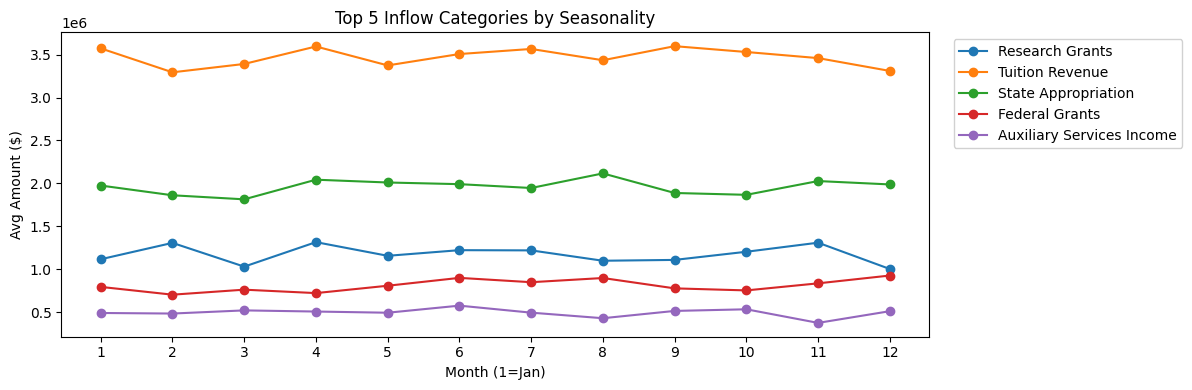

In [19]:
top5 = season_amp.head(5).index.tolist()
plt.figure(figsize=(12,4))
for cat in top5:
    monthly_avg = df.groupby('Month_Num')[cat].mean()
    plt.plot(monthly_avg.index, monthly_avg, marker='o', label=cat)

plt.xticks(range(1,13))
plt.xlabel("Month (1=Jan)")
plt.ylabel("Avg Amount ($)")
plt.title("Top 5 Inflow Categories by Seasonality")

# 1) Shrink the plot on the right to make room for the legend
plt.subplots_adjust(right=0.75)

# 2) Place the legend outside the plot area:
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()


In [20]:
# 3) Compute seasonality amplitude
season_amp = {}
for cat in outflow_cols:
    monthly_avg = df.groupby('Month_Num')[cat].mean()
    amp = monthly_avg.max() - monthly_avg.min()
    season_amp[cat] = amp

season_amp = pd.Series(season_amp).sort_values(ascending=False)
print("Seasonal Amplitude (highest to lowest):")
print(season_amp.to_frame('Amplitude'), "\n")

Seasonal Amplitude (highest to lowest):
                           Amplitude
Faculty Salaries             332,218
Staff Salaries               309,502
Scholarship Disbursements    213,963
Facilities Maintenance       174,954
Debt Service                 161,630
Utility Expenses             149,247
Academic Program Costs        87,275
Marketing & Outreach          69,828
Administrative Expenses       68,871
IT Infrastructure Costs       60,258
 tudent Services              47,195



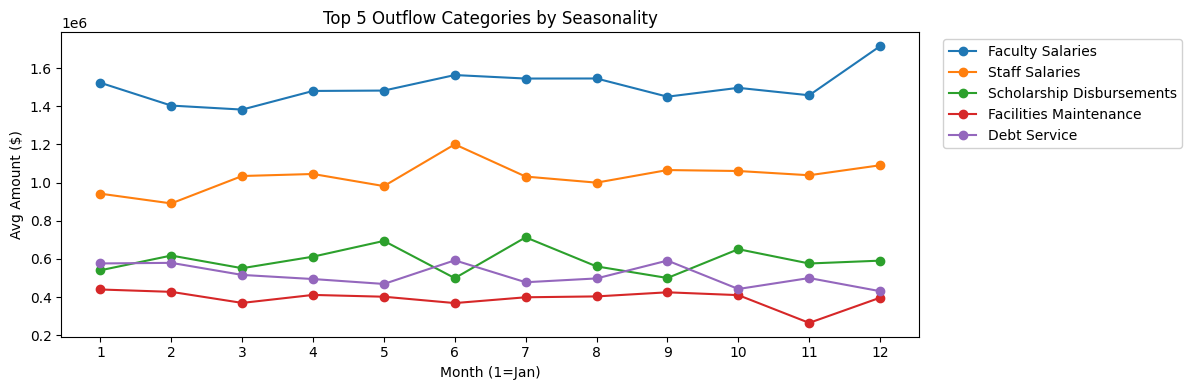

In [21]:
top5 = season_amp.head(5).index.tolist()
plt.figure(figsize=(12,4))
for cat in top5:
    monthly_avg = df.groupby('Month_Num')[cat].mean()
    plt.plot(monthly_avg.index, monthly_avg, marker='o', label=cat)

plt.xticks(range(1,13))
plt.xlabel("Month (1=Jan)")
plt.ylabel("Avg Amount ($)")
plt.title("Top 5 Outflow Categories by Seasonality")

# 1) Shrink the plot on the right to make room for the legend
plt.subplots_adjust(right=0.75)

# 2) Place the legend outside the plot area:
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()


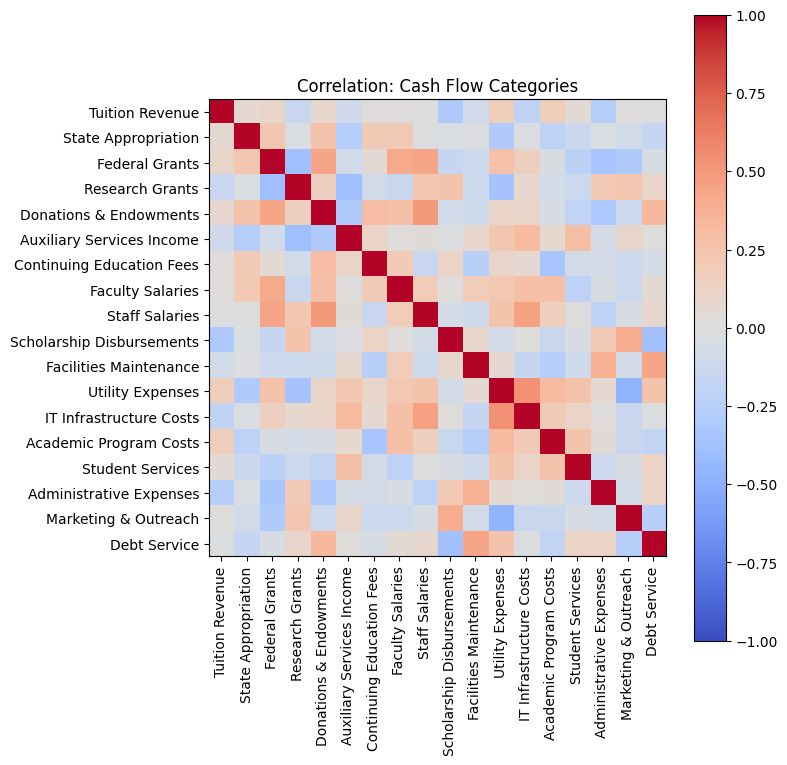

In [23]:
# ---------- Correlation Matrix -----------
cats = inflow_cols + outflow_cols
corr = df[cats].corr()
plt.figure(figsize=(8,8))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation: Cash Flow Categories")
plt.tight_layout()
plt.show()
# Interpretation: identify strong relationships to inform joint forecasting.

In [24]:
# ─── Identify Risk Months ──────────────────────────────────────────────
mean_net, std_net = df["Net Cash Flow"].mean(), df["Net Cash Flow"].std()
threshold = mean_net - std_net
low_months = df[df["Net Cash Flow"] < threshold][["Month","Net Cash Flow"]]
print("=== Risk Months (Net < Mean – 1·STD) ===")
print(low_months)
# Interpretation: these months may need extra scenario analysis.

=== Risk Months (Net < Mean – 1·STD) ===
       Month  Net Cash Flow
2   Mar-2023      2,490,252
8   Sep-2023      2,550,054
11  Dec-2023      2,253,994
13  Feb-2024      2,341,951
14  Mar-2024      2,462,764
18  Jul-2024      2,545,541


### Descriptive Analysis

In [25]:
df['Cash_Margin_%'] = df['Net Cash Flow'] / df['Total Inflow'] * 100
print(df[['Month','Cash_Margin_%']].describe().round(1))


       Cash_Margin_%
count             24
mean              35
std                4
min               28
25%               31
50%               34
75%               38
max               41


<Axes: xlabel='Month_dt'>

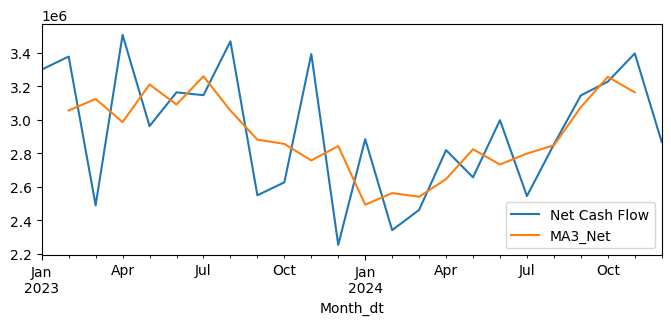

In [26]:
df['MA3_Net'] = df['Net Cash Flow'].rolling(3, center=True).mean()
df.plot('Month_dt',['Net Cash Flow','MA3_Net'], figsize=(8,3))


<Axes: title={'center': 'YoY Inflow Comparison'}, xlabel='Month_dt'>

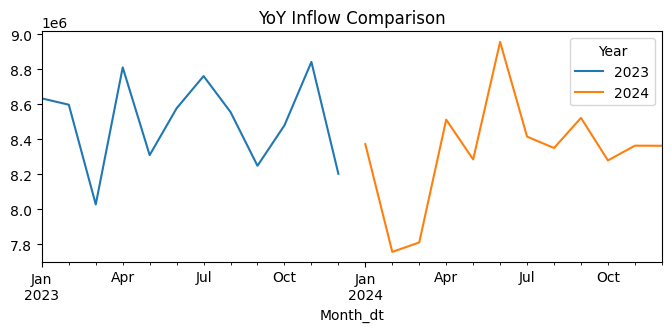

In [27]:
df['Year'] = df['Month_dt'].dt.year
yoy = df.pivot(index='Month_dt',columns='Year',values='Total Inflow')
yoy.plot(figsize=(8,3), title="YoY Inflow Comparison")


### Predictive Analysis

In [28]:
# Build the “inflow” DataFrame
inflow_df = df[['Month_dt', 'Total Inflow']].rename(columns={'Month_dt':'ds', 'Total Inflow':'y'})

# Build the “outflow” DataFrame
outflow_df = df[['Month_dt', 'Total Outflow']].rename(columns={'Month_dt':'ds', 'Total Outflow':'y'})


In [29]:
# Fit Total Inflow model
m_in = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_in.fit(inflow_df)

# Fit Total Outflow model
m_out = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m_out.fit(outflow_df)


21:42:20 - cmdstanpy - INFO - Chain [1] start processing
21:43:04 - cmdstanpy - INFO - Chain [1] done processing
21:43:05 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Produce a “future” DataFrame for 12 months ahead
future_in = m_in.make_future_dataframe(periods=12, freq='M')
future_out = m_out.make_future_dataframe(periods=12, freq='M')

# Generate the forecasts
forecast_in = m_in.predict(future_in)
forecast_out = m_out.predict(future_out)


C:\Users\16096\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


#### Predicted Total Inflow for next 12months (Jan25-Dec25)

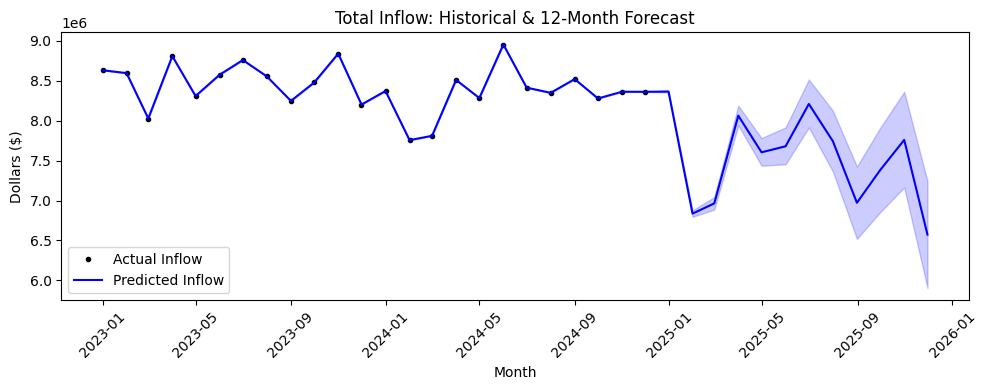

In [31]:
plt.figure(figsize=(10,4))
plt.plot(inflow_df['ds'], inflow_df['y'], 'k.', label='Actual Inflow')
plt.plot(forecast_in['ds'], forecast_in['yhat'], 'b-', label='Predicted Inflow')
plt.fill_between(forecast_in['ds'], forecast_in['yhat_lower'], forecast_in['yhat_upper'],
                 color='b', alpha=0.2)
plt.title("Total Inflow: Historical & 12-Month Forecast")
plt.xlabel("Month")
plt.ylabel("Dollars ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Predicted Total Outflow for next 12months (Jan25-Dec25)

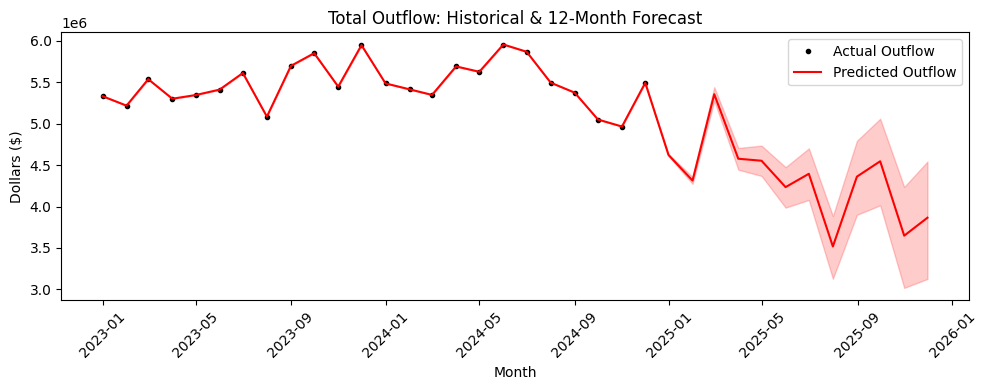

In [32]:
plt.figure(figsize=(10,4))
plt.plot(outflow_df['ds'], outflow_df['y'], 'k.', label='Actual Outflow')
plt.plot(forecast_out['ds'], forecast_out['yhat'], 'r-', label='Predicted Outflow')
plt.fill_between(forecast_out['ds'], forecast_out['yhat_lower'], forecast_out['yhat_upper'],
                 color='r', alpha=0.2)
plt.title("Total Outflow: Historical & 12-Month Forecast")
plt.xlabel("Month")
plt.ylabel("Dollars ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Predicted Total Net Cashflow for next 12months (Jan25-Dec25)

In [34]:
 # Extract ds and yhat for quick merging
pred_in = forecast_in[['ds','yhat']].rename(columns={'yhat':'Inflow_Pred'})
pred_out = forecast_out[['ds','yhat']].rename(columns={'yhat':'Outflow_Pred'})

# Merge on ‘ds’
pred = pred_in.merge(pred_out, on='ds', how='inner')

# Compute Net Cash (Predicted)
pred['Net_Cash_Pred'] = pred['Inflow_Pred'] - pred['Outflow_Pred']


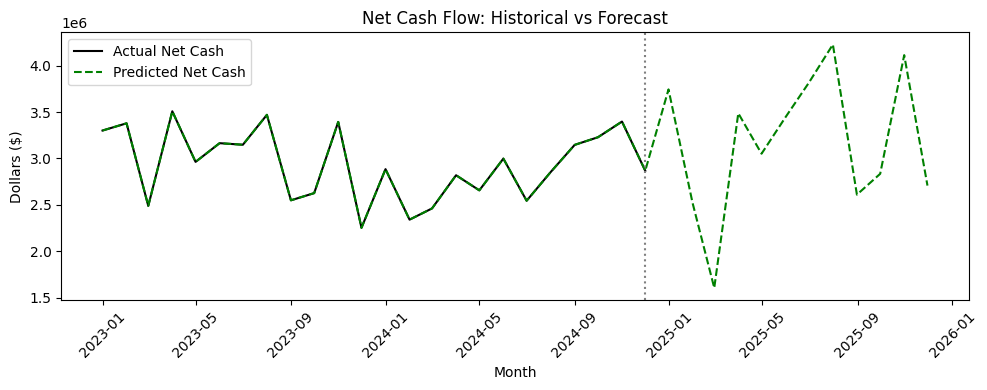

In [35]:
# Build a DataFrame for historical net cash
hist_net = df[['Month_dt','Net Cash Flow']].rename(columns={'Month_dt':'ds','Net Cash Flow':'Net_Cash_Actual'})

# Merge historical (only up to Dec 2024) with predicted
#      To combine, ensure ds is same type, then concat
combined_net = pd.concat([
    hist_net.set_index('ds')['Net_Cash_Actual'],
    pred.set_index('ds')['Net_Cash_Pred']
], axis=1)

# Plot
plt.figure(figsize=(10,4))
plt.plot(combined_net.index, combined_net['Net_Cash_Actual'], 'k-', label='Actual Net Cash')
plt.plot(combined_net.index, combined_net['Net_Cash_Pred'], 'g--', label='Predicted Net Cash')
plt.axvline(pd.to_datetime("2024-12-01"), color='gray', linestyle=':')  # vertical divider
plt.title("Net Cash Flow: Historical vs Forecast")
plt.xlabel("Month")
plt.ylabel("Dollars ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Scenario Analysis

In [36]:
# ─── Filter pred down to 2025 only ──────────────────────────────────────
pred_2025 = pred[pred['ds'] >= pd.to_datetime("2025-01-01")].copy().reset_index(drop=True)

In [37]:
print("=== 2025 Forecast Sample ===")
print(pred_2025[['ds','Inflow_Pred','Outflow_Pred','Net_Cash_Pred']].head(), "\n")

# ───────── Identify “Flexible” Outflow Categories (Relative Amplitude) ────
df['Month_Num'] = df['Month_dt'].dt.month

season_amp  = {}
mean_vals   = {}
for cat in outflow_cols:
    monthly_avg     = df.groupby('Month_Num')[cat].mean()
    season_amp[cat] = monthly_avg.max() - monthly_avg.min()
    mean_vals[cat]  = df[cat].mean()

season_amp   = pd.Series(season_amp)
mean_vals    = pd.Series(mean_vals)
relative_amp = (season_amp / mean_vals).sort_values(ascending=False)
threshold_rel = relative_amp.median()

# “Flexible” = categories whose month-to-month amplitude (as % of mean) > median
flexible_by_rel = relative_amp[relative_amp > threshold_rel].index.tolist()

print("=== Relative Amplitude for Each Outflow Category ===")
print(relative_amp.to_frame(name='RelativeAmp'), "\n")
print(f"Median RelativeAmplitude = {threshold_rel:.3f}\n")
print("Flexible categories (RelAmp > median):")
print(flexible_by_rel, "\n")

=== 2025 Forecast Sample ===
          ds  Inflow_Pred  Outflow_Pred  Net_Cash_Pred
0 2025-01-31    6,836,376     4,313,690      2,522,686
1 2025-02-28    6,964,355     5,356,705      1,607,650
2 2025-03-31    8,064,041     4,577,423      3,486,619
3 2025-04-30    7,604,685     4,553,085      3,051,600
  2025-05-31    7,679,985     4,234,638      3,445,347

=== Relative Amplitude for Each Outflow Category ===
                           RelativeAmp
Utility Expenses                     0
Marketing & Outreach                 0
Facilities Maintenance               0
Administrative Expenses              0
Scholarship Disbursements            0
Debt Service                         0
Staff Salaries                       0
Student Services                     0
Academic Program Costs               0
IT Infrastructure Costs              0
 aculty Salaries                     0

Median RelativeAmplitude = 0.314

Flexible categories (RelAmp > median):
['Utility Expenses', 'Marketing & Outreach', 

In [38]:
# ─────────── Define Prescriptive Scenario Function for 2025 ─────────────────
def scenario_2025(inflow_cuts, min_net_cash=0):

    #  Historical share of each inflow category (2023–2024)
    inflow_shares = df[inflow_cols].sum() / df['Total Inflow'].sum()
    
    # Copy pred_2025 → pa
    pa = pred_2025[['ds','Inflow_Pred','Outflow_Pred','Net_Cash_Pred']].copy()
    pa['Inflow_Adj'] = pa['Inflow_Pred']
    
    #  Apply each inflow cut proportionally: Inflow_Adj = Inflow_Adj * (1 − pct × share)
    for cat, pct in inflow_cuts.items():
        if cat not in inflow_shares:
            raise ValueError(f"Inflow category '{cat}' not recognized.")
        share = inflow_shares[cat]
        pa['Inflow_Adj'] = pa['Inflow_Adj'] * (1 - pct * share)
    
    # Compute adjusted Net Cash
    pa['Net_Cash_Adj'] = pa['Inflow_Adj'] - pa['Outflow_Pred']
    
    #  Compute Shortfall (if Net_Cash_Adj < min_net_cash)
    pa['Shortfall'] = np.where(pa['Net_Cash_Adj'] < min_net_cash,
                               min_net_cash - pa['Net_Cash_Adj'],
                               0)
    
    #  Allocate each month’s shortfall across flexible_by_rel categories
    avg_vals  = df[flexible_by_rel].mean()
    total_avg = avg_vals.sum()
    cuts_list = []
    
    for _, row in pa.iterrows():
        month = row['ds']
        short = row['Shortfall']
        recs  = {}
        
        if short <= 0:
            # No cuts needed this month
            for cat in flexible_by_rel:
                recs[cat] = 0.0
        else:
            for cat in flexible_by_rel:
                # Allocate in proportion to avg_vals
                recs[cat] = short * (avg_vals[cat] / total_avg)
        
        recs['Shortfall'] = short
        recs['ds']         = month
        cuts_list.append(recs)
    
    cuts_df = pd.DataFrame(cuts_list).set_index('ds')
    return pa, cuts_df


In [39]:
# ─────────── Run Example Scenario & Plot/Display ────────────────────────────
# Example “what-if”: cut Federal Grants by 30%, Research Grants by 20%, require cash ≥ $0
inflow_cuts_example = {
    'Federal Grants': 0.30,
    'Research Grants': 0.20,
    'Tuition Revenue': 0.90
}

pred_2025_adj, cuts_2025 = scenario_2025(inflow_cuts_example, min_net_cash=0)

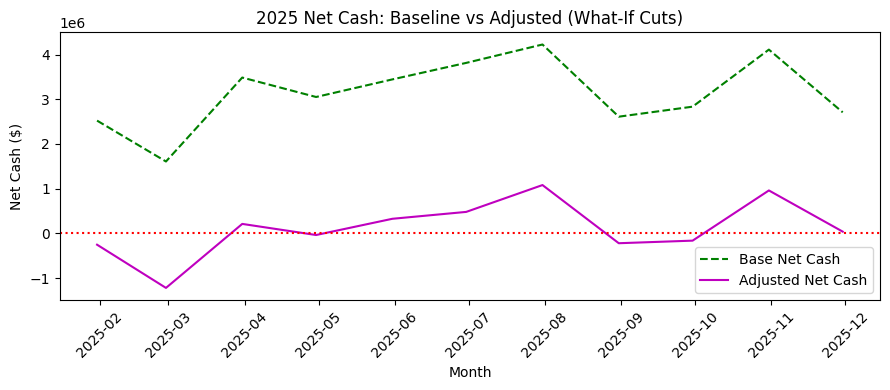

In [40]:
# Plot Base vs Adjusted Net Cash (2025)
plt.figure(figsize=(9,4))
plt.plot(pred_2025_adj['ds'], pred_2025_adj['Net_Cash_Pred'], 'g--', label='Base Net Cash')
plt.plot(pred_2025_adj['ds'], pred_2025_adj['Net_Cash_Adj'], 'm-', label='Adjusted Net Cash')
plt.axhline(0, color='red', linestyle=':')
plt.title("2025 Net Cash: Baseline vs Adjusted (What-If Cuts)")
plt.xlabel("Month")
plt.ylabel("Net Cash ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== 2025 Months with Shortfalls & Recommended Cuts ===



2025-06-03 21:44:10.896 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



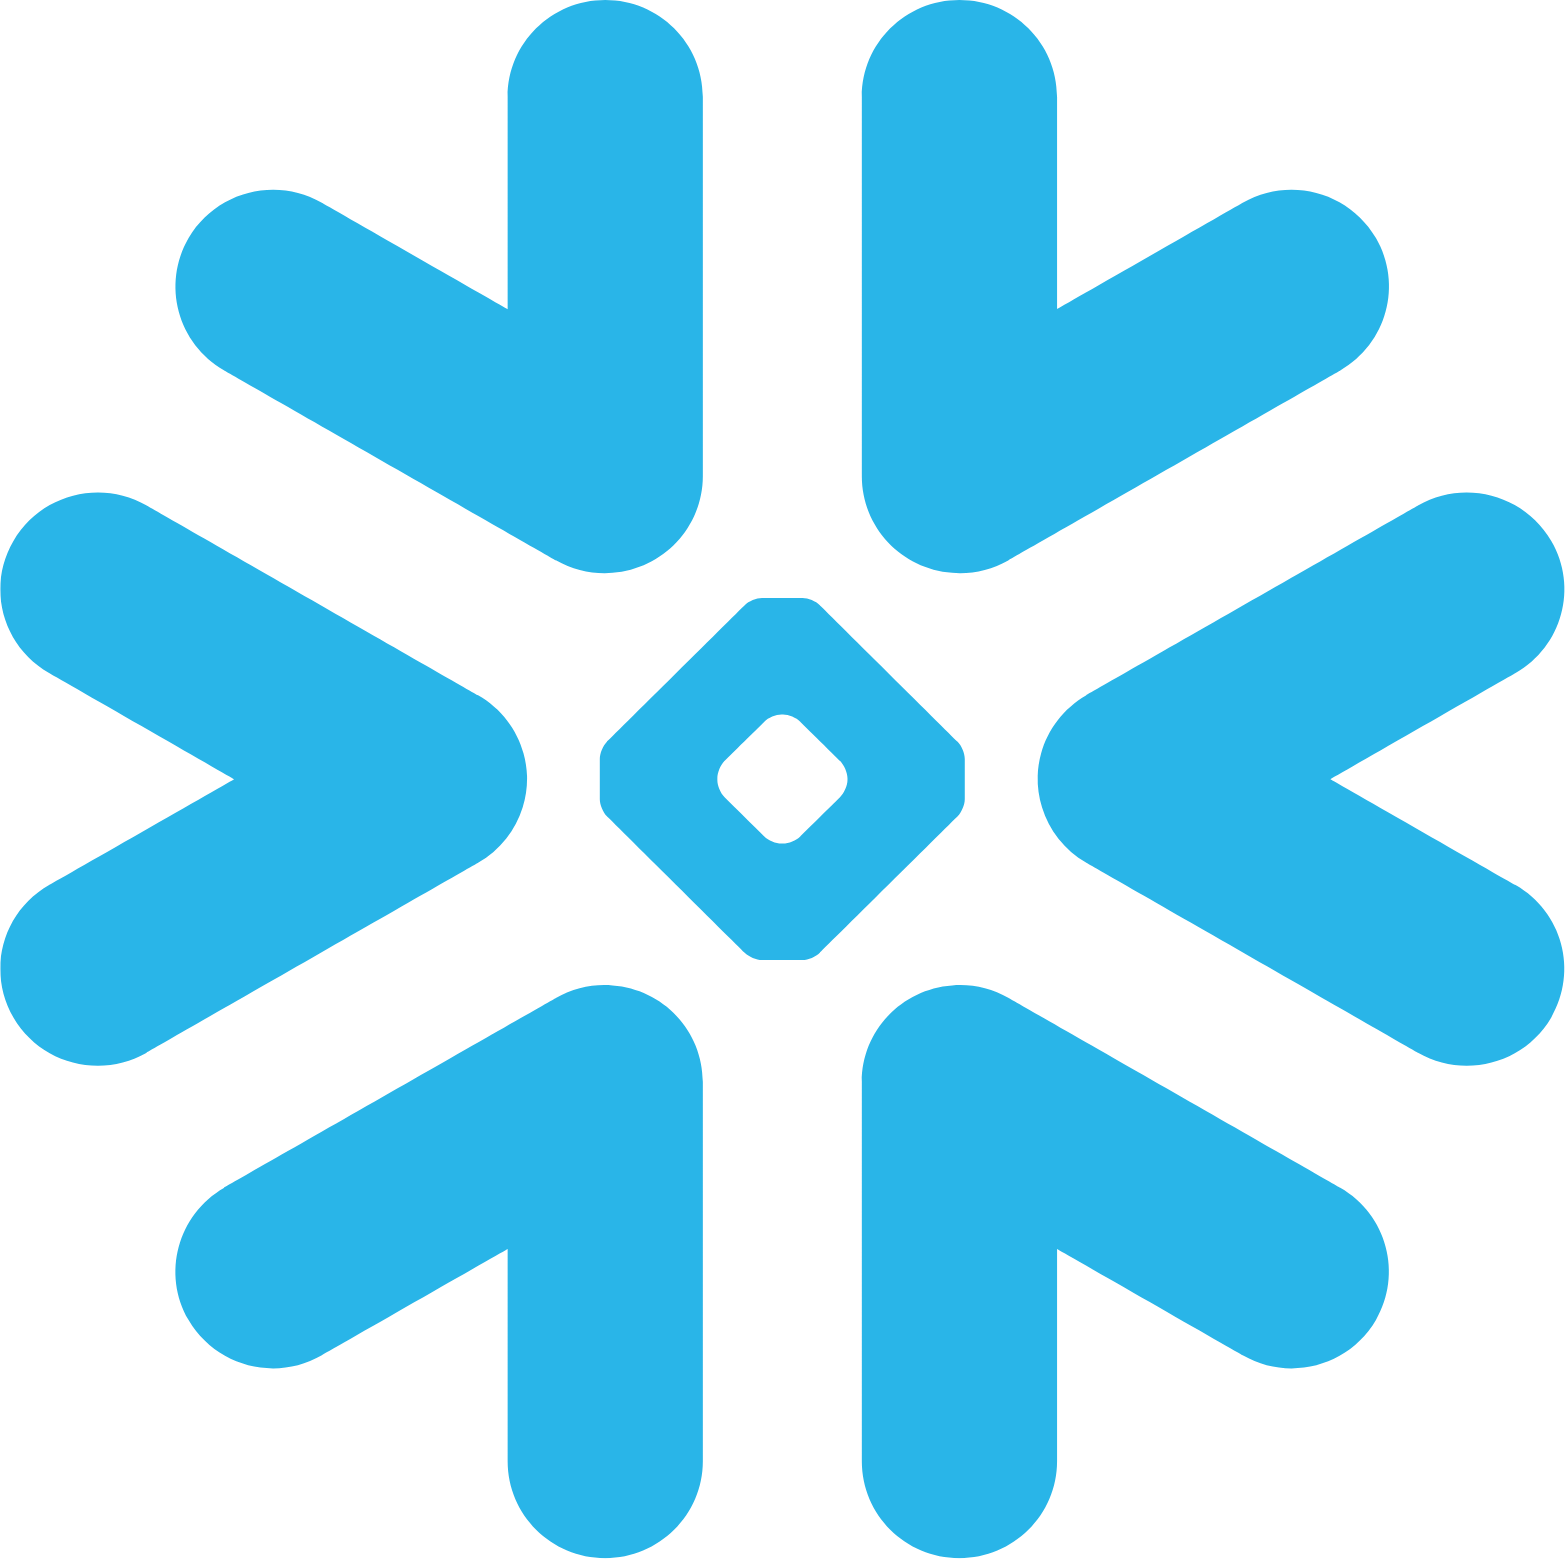

In [41]:
# 5.2) Display months with shortfalls & recommended cuts
shortfall_months = cuts_2025[cuts_2025['Shortfall'] > 0]
print("\n=== 2025 Months with Shortfalls & Recommended Cuts ===\n")
if shortfall_months.empty:
    print("No shortfalls under this scenario (Net Cash ≥ $0 each month).")
else:
    display(shortfall_months[['Shortfall'] + flexible_by_rel])

2025-06-03 21:44:14.462 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



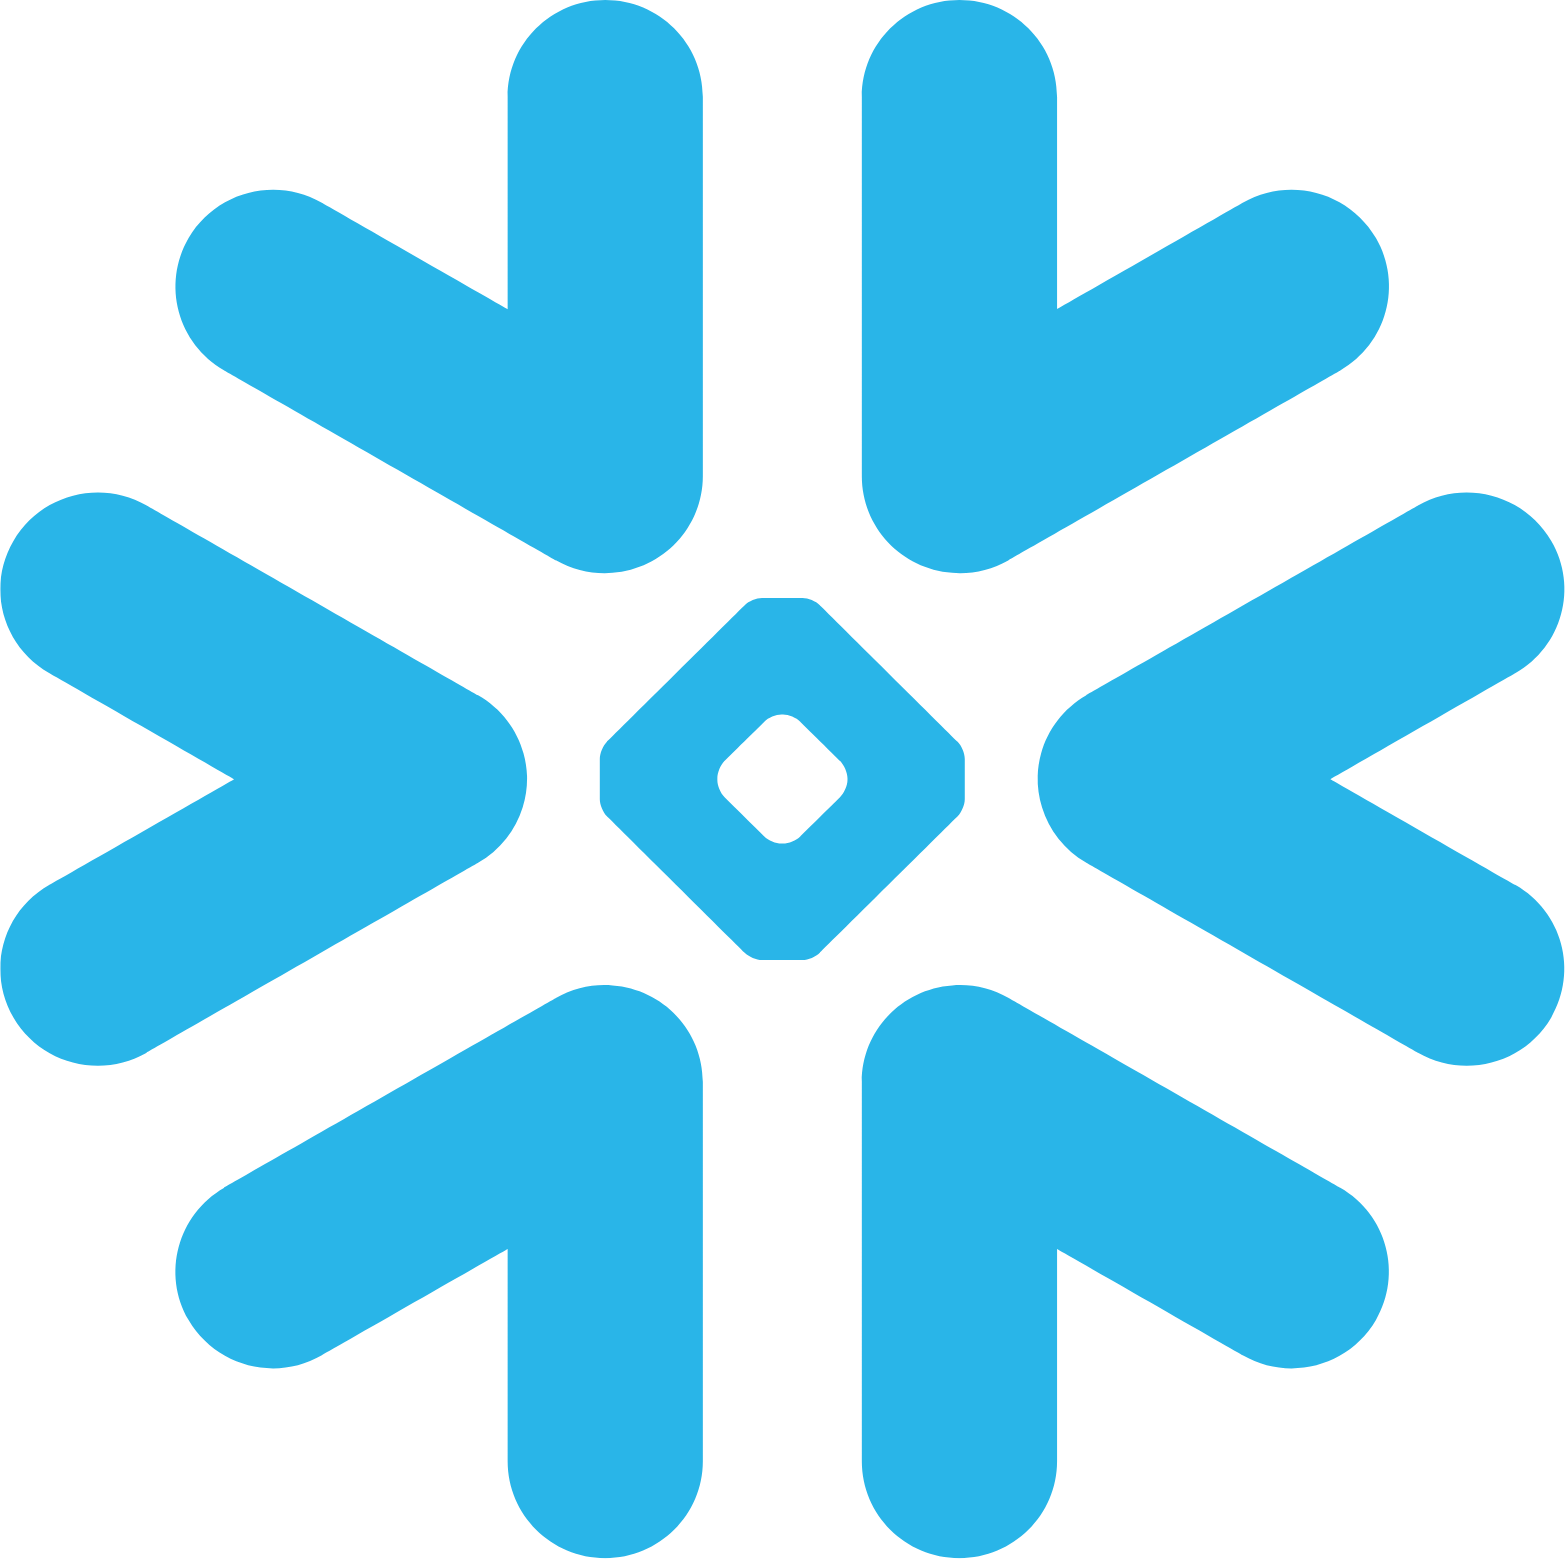

In [42]:
shortfall_months